# Здесь описать цели работы, гипотезу и идеи

In [128]:
import requests
import json
import pandas as pd
import os.path
import numpy as np
import matplotlib.pyplot as plt

# data have many ';' and ','
csv_delimiter = '::'
# indicators to analysis
indicators = [
    'NY.GDP.MKTP.CD',   # GDP (current $)
    'NY.GDP.PCAP.KD',   # GDP per capita (constant 2015 $)
    'FP.CPI.TOTL.ZG',   # Inflation, consumer prices (annual %)
    'SL.UEM.TOTL.ZS',   # Unemployment, total (% of total labor force) (modeled ILO estimate)
    'SP.DYN.CDRT.IN',   # Death rate
]

def download_json(url: str, filepath: str):
    """Download json from url and return result"""
    dataset_request = requests.get(
        url,
        stream=True,
    )
    # write bytes to file
    with open(filepath, "wb") as file:
        for chunk in dataset_request.iter_content(chunk_size=128):
            file.write(chunk)
    # read downloaded json
    with open(filepath, "rt") as file:
        res = json.load(file)
    return res


def download_indicators_list():
    """Get full list of indicators from specified datasets and write to inticators.csv"""
    datasets_ids = [
        "0037712",  # World Development Indicators
        "0037798",  # Global Economical Monitor
    ]
    with open('indicators.csv', 'wt') as indicators_file:
        print("name", "id", "load", sep=csv_delimiter, file=indicators_file)
        for dataset_unique_id in datasets_ids:
            # get dataset info
            dataset_url = f"https://datacatalogapi.worldbank.org/ddhxext/DatasetView?dataset_unique_id={dataset_unique_id}"
            dataset_metadata_path = f"datasets_metadata/{dataset_unique_id}.json"
            indicators = download_json(dataset_url, dataset_metadata_path)
            # get data for each indicator
            for indicator in indicators["Indicator"]:
                # parse url to get values
                name = indicator.split("::")[0]
                id = indicator.split("=")[-1]
                load = 0
                print(name, id, load, sep=csv_delimiter, file=indicators_file)


def get_indicators_data(indicators=None):
    """Download indicators from DataBank. If not specified based on settings from indicators.csv)"""
    all_indicators = pd.read_csv("indicators.csv", delimiter=csv_delimiter, engine='python')
    if indicators:
        needed_indicators = indicators
    else:
        needed_indicators = all_indicators[all_indicators["load"] == 1]['id']
    df = pd.DataFrame(columns=['country', 'date'])
    for id in needed_indicators:
        json_path = f"indicators/json/{id}.json"
        csv_path = f"indicators/csv/{id}.csv"
        # skip already loaded indicators
        if os.path.exists(csv_path):
            print(id, "is already loaded")
        else:
            url = f"https://api.worldbank.org/v2/country/all/indicator/{id}?per_page=20000&format=json"
            print("Downloading", id)
            data = download_json(url, json_path)
            # check if got valid data
            if len(data) != 2:
                print(f"Not found {id}")
                continue
            # convert raw json data to csv
            with open(csv_path, 'wt') as csv_file:
                name = data[1][0]["indicator"]["value"]
                print('country', 'date', name, sep=csv_delimiter, file=csv_file)
                for row in data[1]:
                    country = row["country"]["value"]
                    date = row["date"]
                    value = row["value"]
                    print(country, date, value, sep=csv_delimiter, file=csv_file)
        
        # read downloaded csv
        new = pd.read_csv(csv_path, delimiter=csv_delimiter, engine='python')
        # drop empty rows
        new.dropna(how='any', inplace=True)
        # merge with main dataset
        df = pd.merge(left=df, right=new, how='outer', on=('country', 'date'))

    return df

In [129]:
# download_indicators_list()
raw_df = get_indicators_data(indicators)

NY.GDP.MKTP.CD is already loaded
NY.GDP.PCAP.KD is already loaded
FP.CPI.TOTL.ZG is already loaded
SL.UEM.TOTL.ZS is already loaded
SP.DYN.CDRT.IN is already loaded


In [130]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16722 entries, 0 to 16721
Data columns (total 7 columns):
 #   Column                                                               Non-Null Count  Dtype  
---  ------                                                               --------------  -----  
 0   country                                                              16722 non-null  object 
 1   date                                                                 16722 non-null  int64  
 2   GDP (current US$)                                                    13979 non-null  float64
 3   GDP per capita (constant 2015 US$)                                   13963 non-null  float64
 4   Inflation, consumer prices (annual %)                                11004 non-null  float64
 5   Unemployment, total (% of total labor force) (modeled ILO estimate)  7752 non-null   float64
 6   Death rate, crude (per 1,000 people)                                 16282 non-null  float64
dtypes: fl

# Переименование столбцов

In [131]:
replace_rules = {
    'GDP (current US$)': 'GDP',
    'GDP per capita (constant 2015 US$)': 'GDP per capita',
    'Inflation, consumer prices (annual %)': 'inflation',
    'Unemployment, total (% of total labor force) (modeled ILO estimate)': 'unemployment',
    'Death rate, crude (per 1,000 people)': 'death rate'
}

for a, b in replace_rules.items():
    raw_df[b] = raw_df[a]
    raw_df.drop(columns=[a], inplace=True)

In [132]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16722 entries, 0 to 16721
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   country         16722 non-null  object 
 1   date            16722 non-null  int64  
 2   GDP             13979 non-null  float64
 3   GDP per capita  13963 non-null  float64
 4   inflation       11004 non-null  float64
 5   unemployment    7752 non-null   float64
 6   death rate      16282 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 914.6+ KB


# Отбор стран для анализа

In [133]:
# regions to take into statistics
include_regions = np.array([
       'Afghanistan', 'Albania', 'Algeria', 'American Samoa',
       'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia',
       'Aruba', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas, The',
       'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium',
       'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Cayman Islands', 'Central African Republic', 'Chad',
       'Channel Islands', 'Chile', 'China', 'Colombia', 'Comoros',
       'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire",
       'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czechia', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador',
       'Egypt, Arab Rep.', 'El Salvador', 'Equatorial Guinea', 'Eritrea',
       'Estonia', 'Eswatini', 'Ethiopia', 'Faroe Islands', 'Fiji',
       'Finland', 'France', 'French Polynesia', 'Gabon', 'Gambia, The',
       'Georgia', 'Germany', 'Ghana', 'Gibraltar', 'Greece', 'Greenland',
       'Grenada', 'Guam', 'Guatemala', 'Guinea', 'Guinea-Bissau',
       'Guyana', 'Haiti', 'Honduras', 'Hong Kong SAR, China', 'Hungary',
       'Iceland', 'India', 'Indonesia', 'Iran, Islamic Rep.', 'Iraq',
       'Ireland', 'Isle of Man', 'Israel', 'Italy', 'Jamaica', 'Japan',
       'Jordan', 'Kazakhstan', 'Kenya', 'Kiribati',
       "Korea, Dem. People's Rep.", 'Korea, Rep.', 'Kosovo', 'Kuwait',
       'Kyrgyz Republic', 'Lao PDR', 'Latvia', 'Lebanon', 'Lesotho',
       'Liberia', 'Libya', 'Liechtenstein', 'Lithuania', 'Luxembourg',
       'Macao SAR, China', 'Madagascar', 'Malawi', 'Malaysia', 'Maldives',
       'Mali', 'Malta', 'Marshall Islands', 'Mauritania', 'Mauritius',
       'Mexico', 'Micronesia, Fed. Sts.', 'Moldova', 'Monaco', 'Mongolia',
       'Montenegro', 'Morocco', 'Mozambique', 'Myanmar', 'Namibia',
       'Nauru', 'Nepal', 'Netherlands', 'New Caledonia', 'New Zealand',
       'Nicaragua', 'Niger', 'Nigeria', 'North Macedonia',
       'Northern Mariana Islands', 'Norway', 'Oman', 'Pakistan', 'Palau',
       'Panama', 'Papua New Guinea', 'Paraguay', 'Peru', 'Philippines',
       'Poland', 'Portugal', 'Puerto Rico', 'Qatar', 'Romania',
       'Russian Federation', 'Rwanda', 'Samoa', 'San Marino',
       'Sao Tome and Principe', 'Saudi Arabia', 'Senegal', 'Serbia',
       'Seychelles', 'Sierra Leone', 'Singapore',
       'Sint Maarten (Dutch part)', 'Slovak Republic', 'Slovenia',
       'Solomon Islands', 'Somalia', 'South Africa', 'South Sudan',
       'Spain', 'Sri Lanka', 'St. Kitts and Nevis', 'St. Lucia',
       'St. Martin (French part)', 'St. Vincent and the Grenadines',
       'Sudan', 'Suriname', 'Sweden', 'Switzerland',
       'Syrian Arab Republic', 'Tajikistan', 'Tanzania', 'Thailand',
       'Timor-Leste', 'Togo', 'Tonga', 'Trinidad and Tobago', 'Tunisia',
       'Turkiye', 'Turkmenistan', 'Turks and Caicos Islands', 'Tuvalu',
       'Uganda', 'Ukraine', 'United Arab Emirates', 'United Kingdom',
       'United States', 'Uruguay', 'Uzbekistan', 'Vanuatu',
       'Venezuela, RB', 'Viet Nam', 'Virgin Islands (U.S.)',
       'West Bank and Gaza', 'Yemen, Rep.', 'Zambia', 'Zimbabwe'],
      dtype=object)

In [134]:
# dataset of needed countries
cleared_df = raw_df[raw_df["country"].isin(include_regions)]

N = 5

# arrange by last available year
top_absolute_GDP_countries = cleared_df[cleared_df["date"] == 2023].sort_values(    # group 1
    "GDP", ascending=False
)[:N]["country"].reset_index(drop=True)
top_GDP_per_capita_countries = cleared_df[cleared_df["date"] == 2023].sort_values(  # group 2
    "GDP per capita", ascending=False
)[:N]["country"].reset_index(drop=True)

In [135]:
print(
    f"Top {N} countries by GDP (group 1):",
    top_absolute_GDP_countries,
    f"Top {N} countries by GDP per capite (group 2):",
    top_GDP_per_capita_countries,
    sep="\n",
)

Top 5 countries by GDP (group 1):
0    United States
1            China
2          Germany
3            Japan
4            India
Name: country, dtype: object
Top 5 countries by GDP per capite (group 2):
0     Luxembourg
1        Ireland
2    Switzerland
3         Norway
4      Singapore
Name: country, dtype: object


In [136]:
# create new dataframe with choosed countries
df = cleared_df[cleared_df['country'].isin(pd.concat([top_absolute_GDP_countries, top_GDP_per_capita_countries]))][cleared_df['date'] >= 1990].sort_values('date', ascending=True)
df['group'] = df['country'].isin(top_GDP_per_capita_countries) + 1

C:\Users\redun\AppData\Local\Temp\ipykernel_69588\884460642.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = cleared_df[cleared_df['country'].isin(pd.concat([top_absolute_GDP_countries, top_GDP_per_capita_countries]))][cleared_df['date'] >= 1990].sort_values('date', ascending=True)


In [137]:
df

,country,date,GDP,GDP per capita,inflation,unemployment,death rate,group
7948,Japan,1990,3.185905e+12,28422.213120,3.078516,NaN,6.7,1
12543,Switzerland,1990,2.657636e+11,70063.851690,5.403959,NaN,9.5,2
11710,Singapore,1990,3.614434e+10,23272.700093,3.460753,NaN,4.7,2
10401,Norway,1990,1.197918e+11,49937.455776,4.131033,NaN,10.9,2
8777,Luxembourg,1990,1.277879e+10,66027.075801,3.253767,NaN,9.9,2
...,...,...,...,...,...,...,...,...
13468,United States,2023,2.736094e+13,65020.352929,4.116338,3.625,NaN,1
7915,Japan,2023,4.212945e+12,37079.109220,3.268134,2.575,NaN,1
8744,Luxembourg,2023,8.575501e+10,105996.661497,3.741404,5.188,NaN,2
7385,India,2023,3.549919e+12,2239.250363,5.649143,4.172,NaN,1


In [138]:
from matplotlib import colormaps

# generator object returning different colors
def color_gen_f():
    val = 0
    colors_n = 10
    step = 1
    cmap = colormaps.get_cmap('tab10')
    while True:
        yield cmap(val / colors_n)
        val = (val + step) % colors_n

color_gen = color_gen_f()

# Графики ВВП по отобранным странам

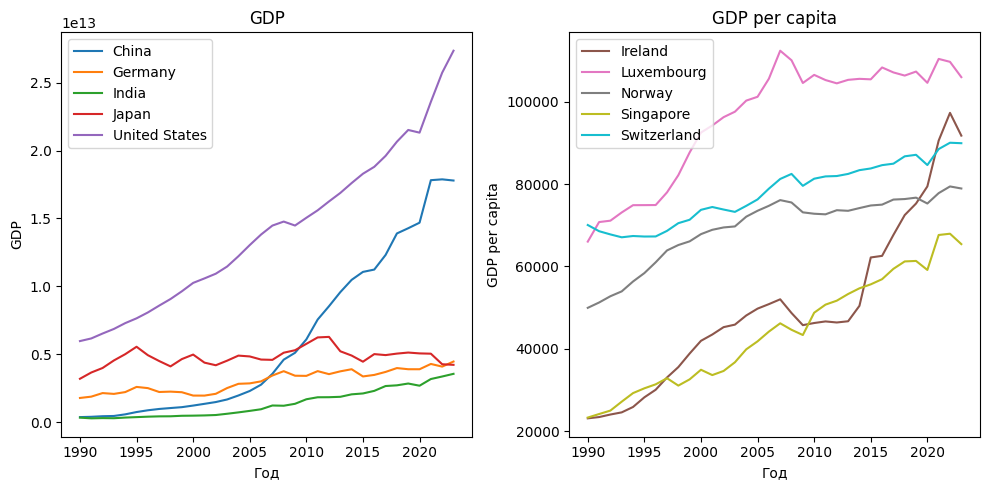

In [139]:
plt.figure("GDP", figsize=(10, 5))

attributes = ["GDP", "GDP per capita"]

for i in range(2):
    axis = plt.subplot(1, 2, i + 1)
    plt.title(attributes[i])
    for country, series in df[df['group'] == i + 1].groupby(['country']):
        axis = series.plot(x='date', y=attributes[i], label=country[0], xlabel='Год', ylabel=attributes[i], ax=axis, color=next(color_gen))

plt.tight_layout()
plt.show()

# Макроэкономика
### Инфляция и безработица

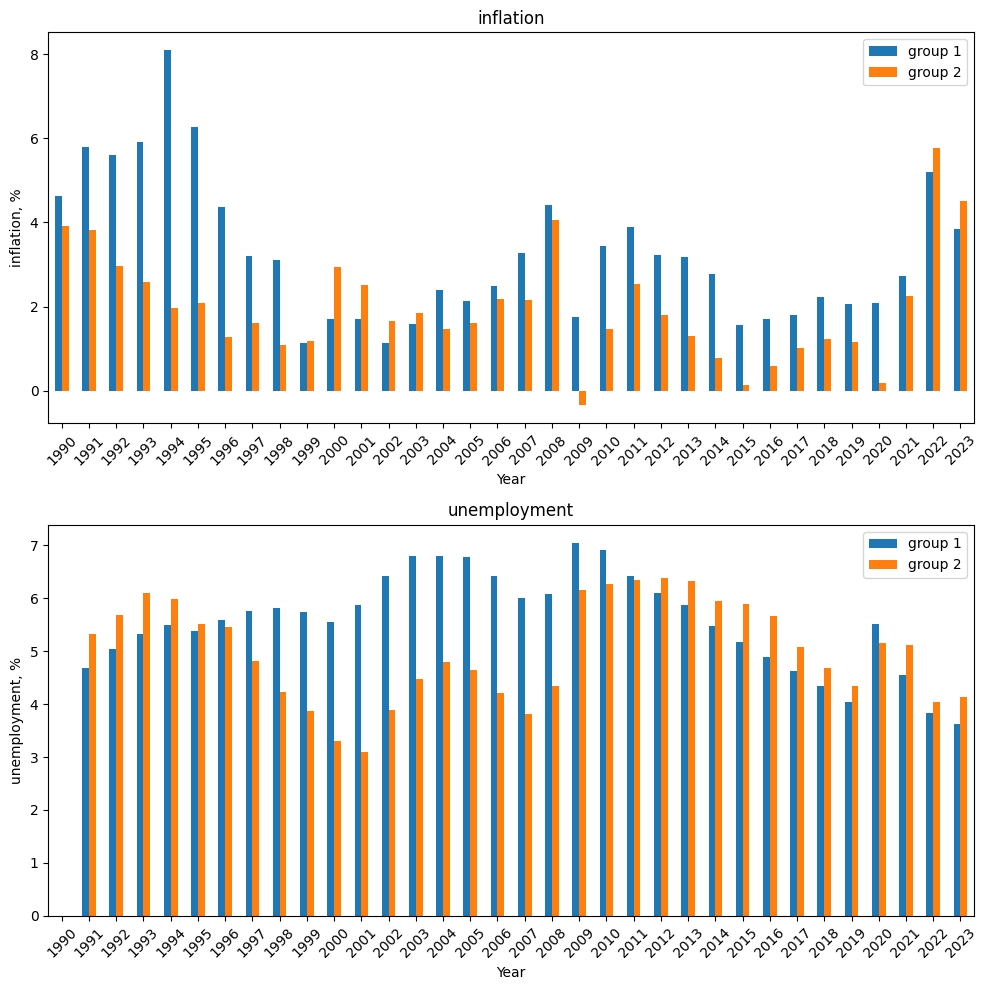

In [140]:
fig = plt.figure("Inflation and unemployment", figsize=(10, 10))

attributes = ["inflation", "unemployment"]
colors = [next(color_gen), next(color_gen)]


for i in range(2):
    axis = plt.subplot(2, 1, i + 1)
    plt.title(attributes[i])

    means = (
        df.groupby(["date", "group"])
        .aggregate({attributes[i]: "mean"})
        .unstack(level=1)
    )
    axis = means.plot(
        kind="bar",
        ylabel=attributes[i] + ", %",
        rot=45,
        xlabel="Year",
        ax=axis,
        color=colors,
    )
    plt.legend(labels=['group 1', 'group 2'])
    

plt.tight_layout()
plt.show()